### Import librerie

In [1]:
import time

start_time = time.time()
    
#import cx_Oracle --> da citare nella tesi
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
import numpy as np
#from matplotlib import pyplot
import matplotlib.pyplot as plt
#from pandas.plotting import autocorrelation_plot
#import plotly.figure_factory as ff
#from statsmodels.tsa.arima.model import ARIMA
from matplotlib import gridspec
#from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


### Leggo il file JSON

In [2]:
import json

with open ("Tesi/Codice/parametri_esecuzione.json", "r") as read_file:
    data = json.load(read_file)

#Salvo in variabili locali il contenuto del file JSON
percentile_distr_high = data["soglia_high"]
percentile_distr_high_perc = percentile_distr_high*100 
percentile_distr_low = data["soglia_low"]
percentile_distr_low_perc = percentile_distr_low*100
scrittura_db = data["scrittura_db"]
scrittura_grafici = data["scrittura_grafici"]
interq_threshold = data["soglia_interquartile"]

###### Mi creo delle variabili per il range temporale che intendo analizzare

In [3]:
###***DATE***###

#Start: 14 Giugno 2021
today                = pd.Timestamp.today().date() 
delta_day_test_end   = 6
delta_day_train_end  = 180 

In [4]:
#Eseguo questo perché nel dataset che ho a disposizione non posso aggiornare di giorno in giorno la data, ma ne uso
#una specifica
today = dt.datetime.strptime('2021/06/14','%Y/%m/%d').date()

##### Creo train e test set

In [5]:
#elabDate = datetime.now().strftime("%Y-%m-%d") #Data elaborazione

test_end   = today#pd.Timestamp.today().date()
test_start = test_end - timedelta(days = delta_day_test_end)
datelist_test = pd.date_range(start=test_start, end=test_end).tolist()
lista_date_test=[]
for i in range(0, len(datelist_test)):
    data = datelist_test[i].date()
    lista_date_test.append(data)
    
train_end   = test_start - timedelta(days = 1)
train_start = train_end  - timedelta(days = delta_day_train_end)
datelist_train = pd.date_range(start=train_start, end=train_end).tolist()
lista_date_train=[]
for i in range(0, len(datelist_train)):
    data = datelist_train[i].date()
    lista_date_train.append(data)

##### Funzione utile per il calcolo di soglia interquartile

In [6]:
# FUNZIONE PER CALCOLO SOGLIE  Q3 + 1.5(Q3-Q1) e Q1 - 1.5(Q3-Q1)
def interquartile_threshold(dataframe, check_id):
    if check_id not in [17,18,3,8,16]:
        threshold = df["DAILY_QTY"].quantile(0.75) + 1.5*(df["DAILY_QTY"].quantile(0.75) - df["DAILY_QTY"].quantile(0.25))
    if check_id in [17,18]:
        threshold = df["RATIO"].quantile(0.75) + 1.5*(df["RATIO"].quantile(0.75) - df["RATIO"].quantile(0.25))
    if check_id in [3,8,16]:
        threshold = df["DAILY_QTY"].quantile(0.25) - (1.5*(df["DAILY_QTY"].quantile(0.75) - df["DAILY_QTY"].quantile(0.25)))
    
    return threshold

### Leggo i dataset:
- ordini totali
- ordini bloccati
- df_actual_threshold (soglie attualmente impostate dai Metal Manager)
- black_list

In [7]:
tot_orders = pd.read_csv("Tesi/Dataset/ordini_totali.csv")
tot_blocc_orders = pd.read_csv("Tesi/Dataset/tot_ordini_bl.csv")
df_actual_thresholds = pd.read_csv("Tesi/Dataset/df_actual_thresholds.csv")
black_list = pd.read_csv("Tesi/Dataset/black_list.csv")

ordini_totali = tot_orders.drop_duplicates() #NO DUPLICATI TRA SVIL E PROD
ordini_totali= ordini_totali[["ID","RD_KEY","SOLD_TO_PT","DAILY_QTY", "F","CONVERSION_NOT_SUCCEDED","NF_KEY","CONFIRMED","SALES_DOC_TY","DOC_NUM","ITEM",
                  "COMPANY_CODE","RES_QTY_MET","ORDER_QTY","WORKED_DATE", "BOOKING_FR"]]
    
tot_ordini_bl = tot_blocc_orders.drop_duplicates()

### Creo il set di SALES
Utili per l'analisi dei check 1,2,3,5,18,21

In [8]:
sales = ordini_totali[(ordini_totali["CONVERSION_NOT_SUCCEDED"] == 'A') & (ordini_totali["F"] == 'O') & (~ordini_totali["SALES_DOC_TY"].isin(["OVER","UNDE"]))]
sales_debooking = sales[sales["DAILY_QTY"] < 0]
sales = sales[sales["DAILY_QTY"] > 0]

In [9]:
#1) Prima trasformo in formato 'datetime' l'object
sales["WORKED_DATE"] = pd.to_datetime(sales["WORKED_DATE"])

In [10]:
#2) Tolgo l'orario dal 'datetime'
sales["WORKED_DATE"] = sales["WORKED_DATE"].dt.date

In [11]:
#3) Mi creo il set di train e di test
sales_train = sales[sales["WORKED_DATE"].isin(lista_date_train)]
sales_test = sales[sales["WORKED_DATE"].isin(lista_date_test)]

#### Check 1 e 3

In [12]:
#Per i check 1 e 3 creo un nuovo dataframe che risponde alle regole dei check
check_1_3 = pd.DataFrame(sales_train.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE"])["DAILY_QTY"].sum()).reset_index()
check_1_3_test = pd.DataFrame(sales_test.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE"])["DAILY_QTY"].sum()).reset_index()
        
df_c1_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
df_c3_soglie_1 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_1_3.COMPANY_CODE.unique():
    for i in check_1_3.NF_KEY.unique():
        df = check_1_3[(check_1_3["COMPANY_CODE"]==j) & (check_1_3["NF_KEY"]==i)]
        if len(df) != 0:
            soglia_1 = df.DAILY_QTY.quantile(percentile_distr_high)
            soglia_3 = df.DAILY_QTY.quantile(percentile_distr_low)
            if interq_threshold == 'si':
                #iq_soglia_1 = interquartile_threshold(df, 1)
                iq_soglia_3 = interquartile_threshold(df, 3)
                #if iq_soglia_1 > soglia_1:
                #    soglia_1 = iq_soglia_1
                #    print('OK')
                if (iq_soglia_3 < soglia_3) & (iq_soglia_3 >= 0):
                    soglia_3 = iq_soglia_3
                    #print('Soglia interq attivata')
            new_row_1 = {"CC":j,"metallo":i,"soglia":soglia_1}
            new_row_3 = {"CC":j,"metallo":i,"soglia":soglia_3}
            df_c1_soglie_995 = df_c1_soglie_995.append(new_row_1, ignore_index=True)
            df_c3_soglie_1 = df_c3_soglie_1.append(new_row_3, ignore_index=True)
    
df_c1_soglie_995["check_id"] = 1
df_c3_soglie_1["check_id"] = 3

#### Stampo i grafici

In [13]:
import function as f

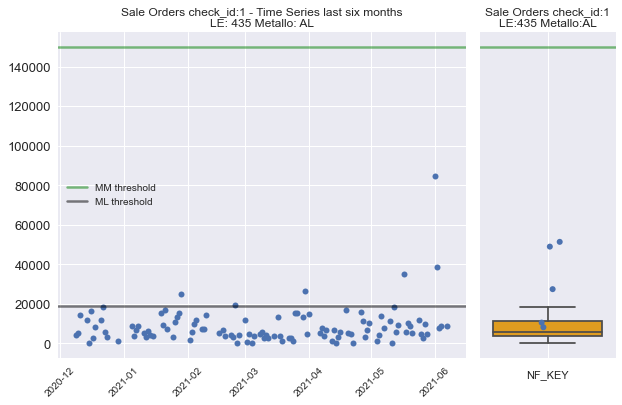

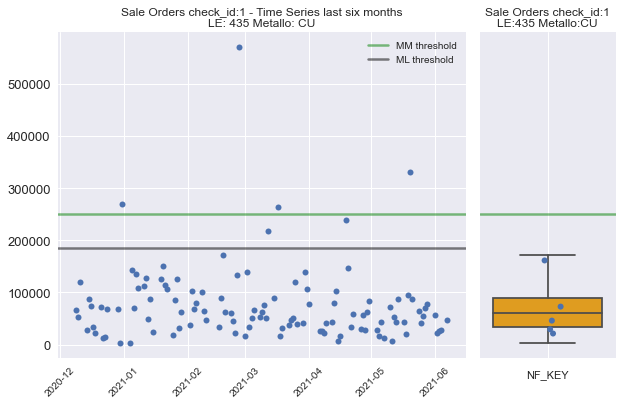

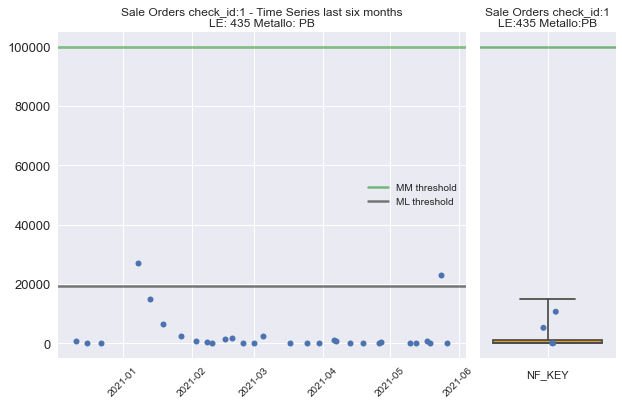

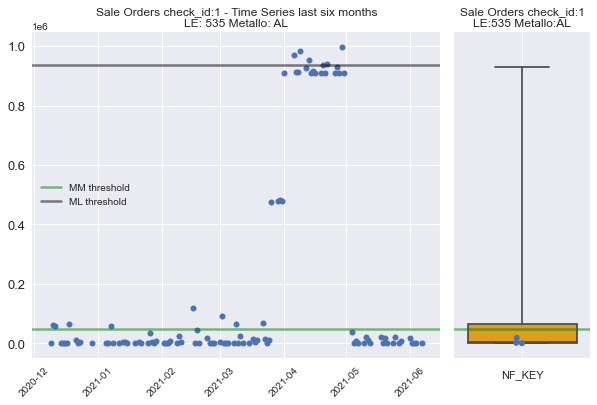

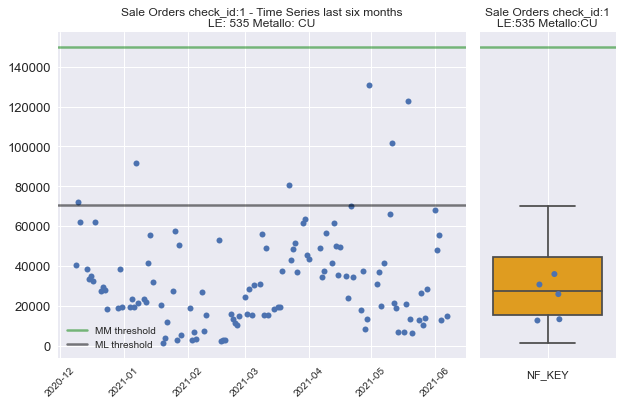

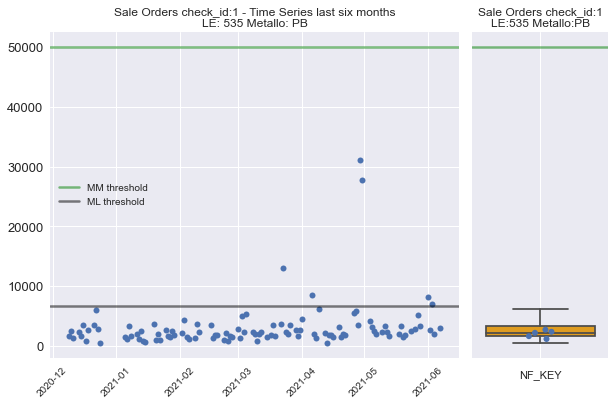

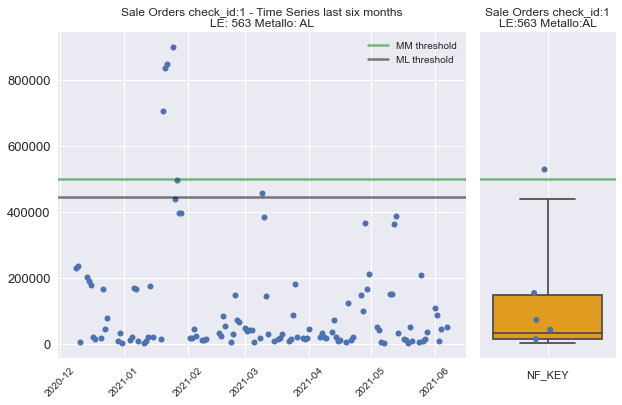

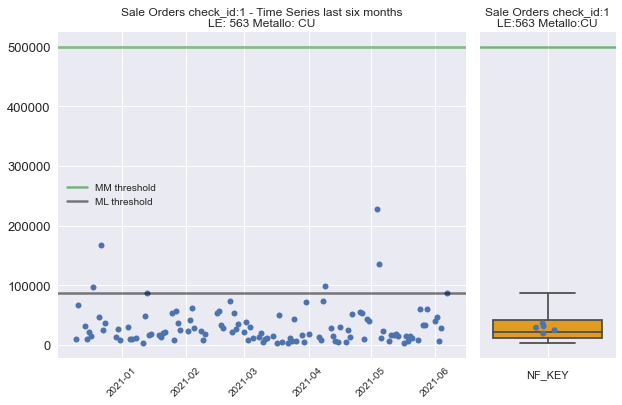

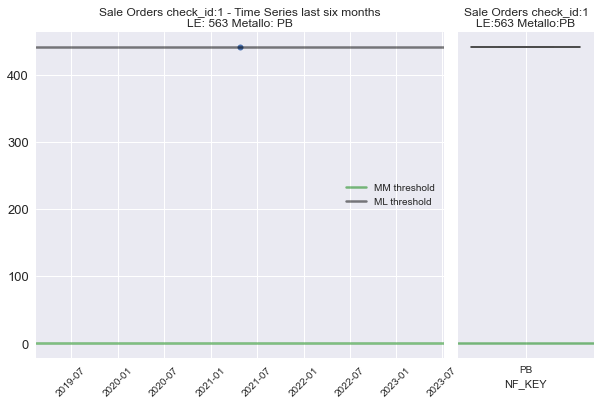

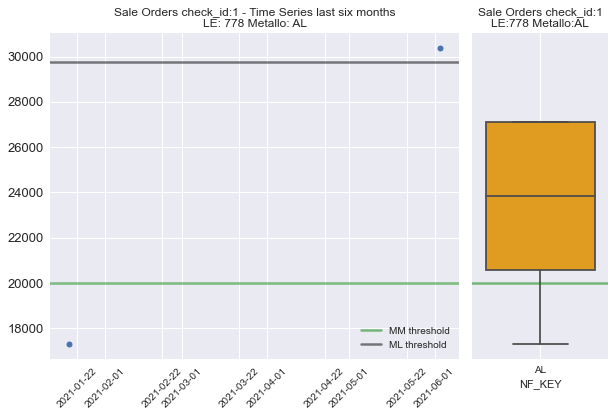

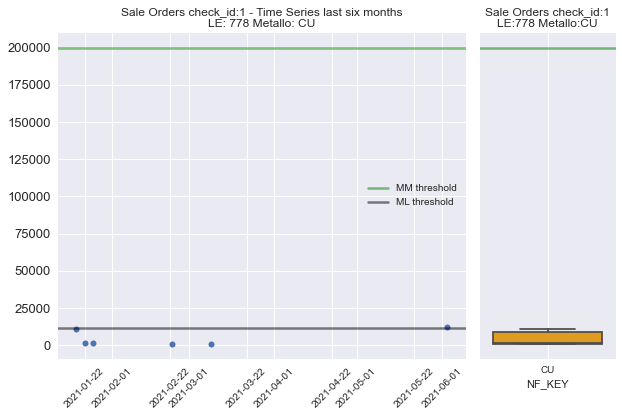

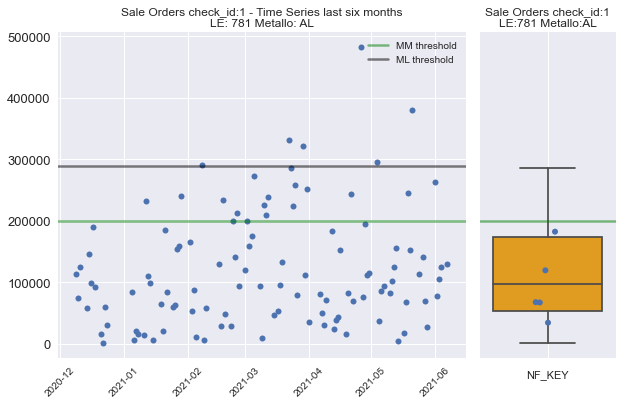

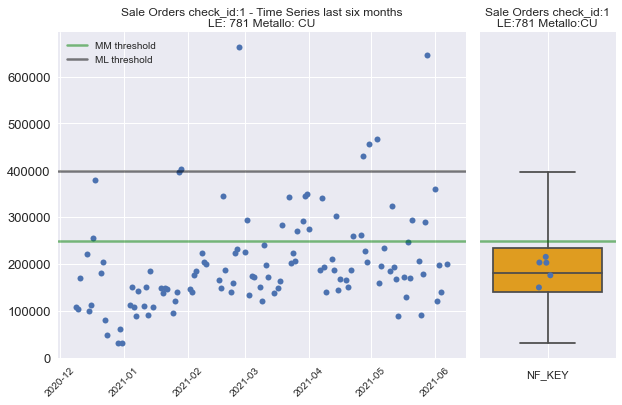

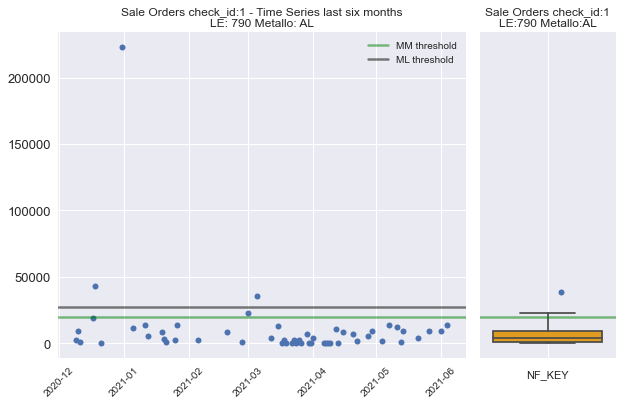

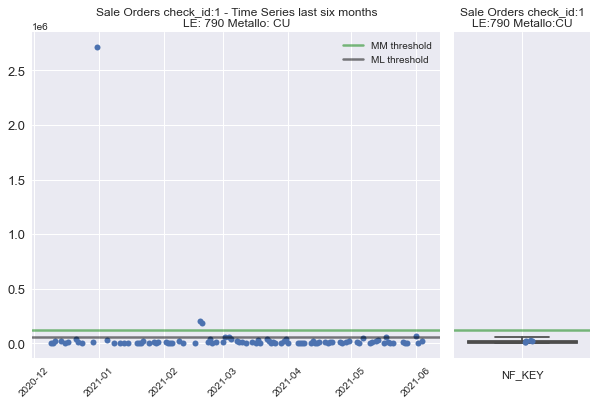

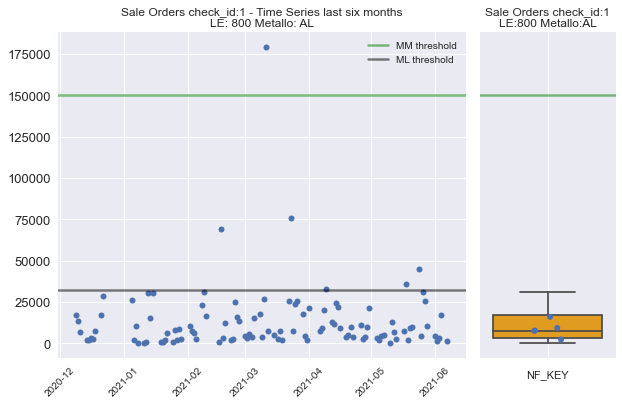

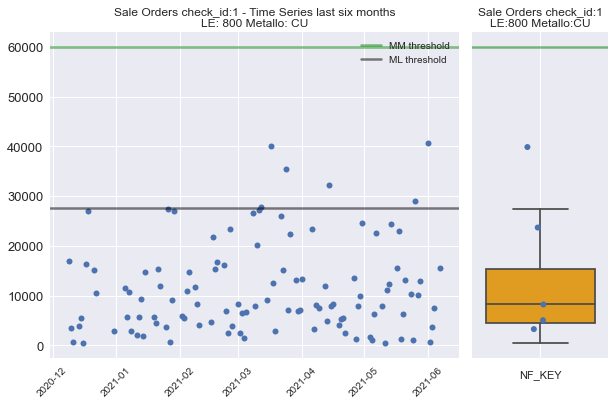

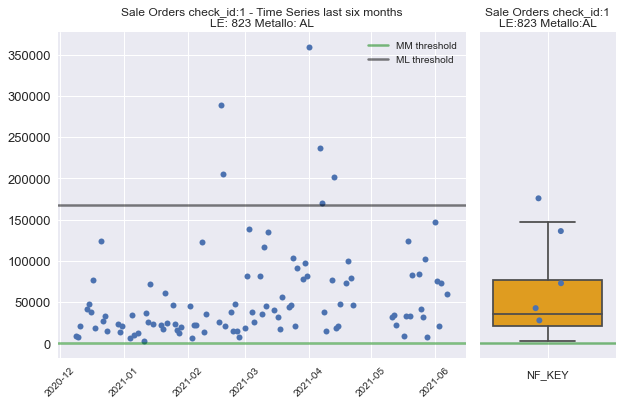

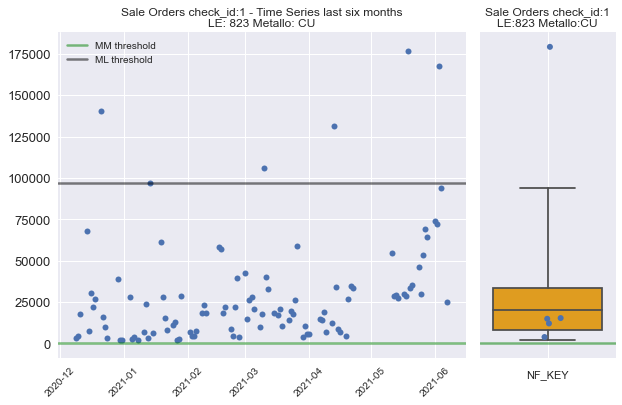

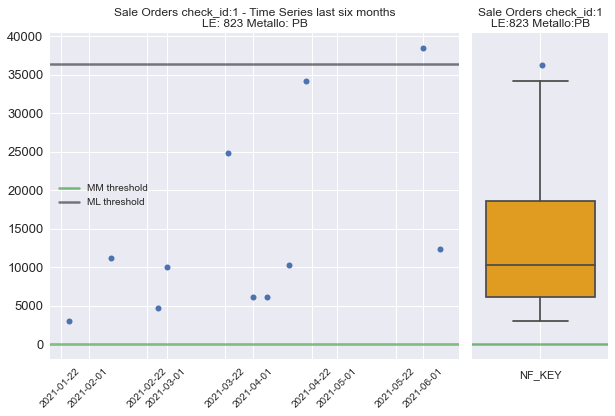

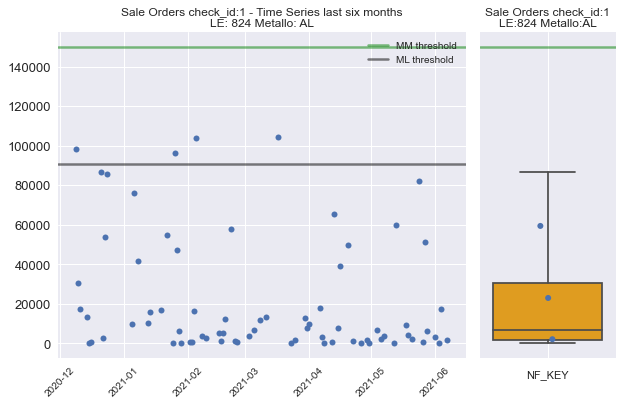

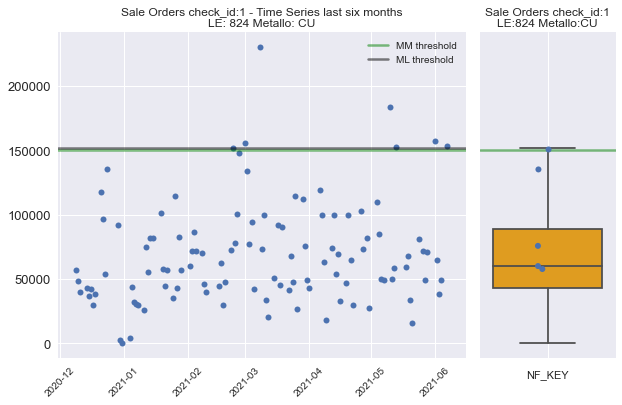

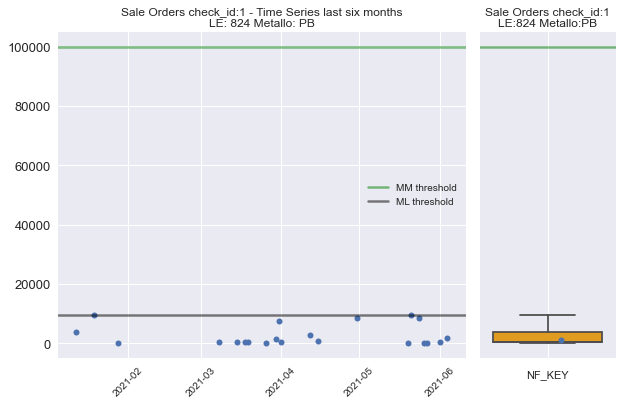

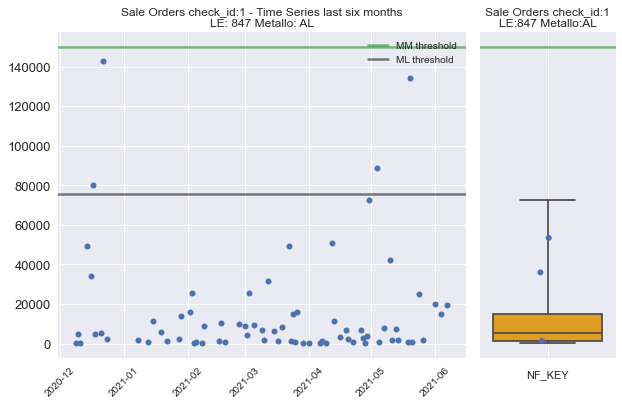

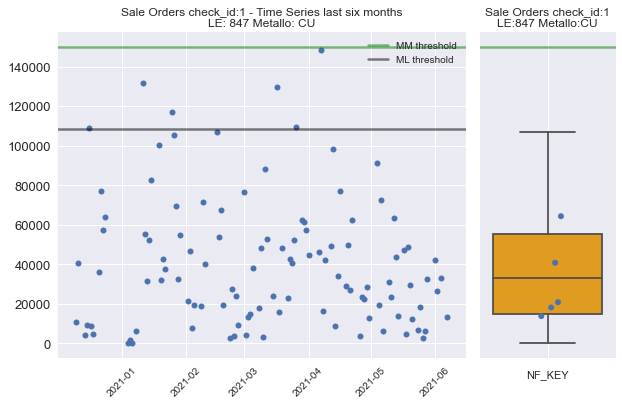

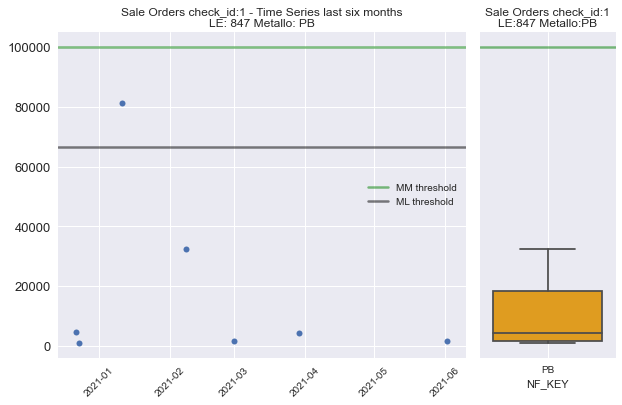

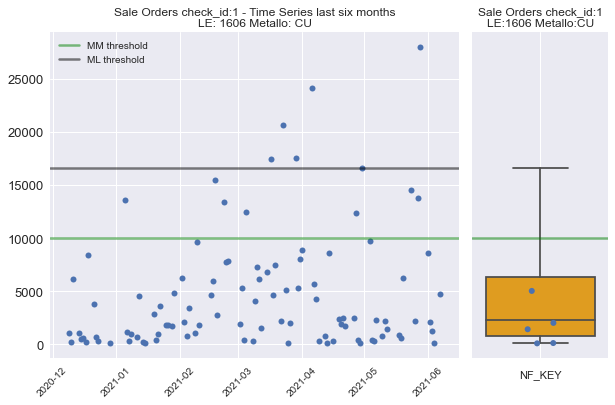

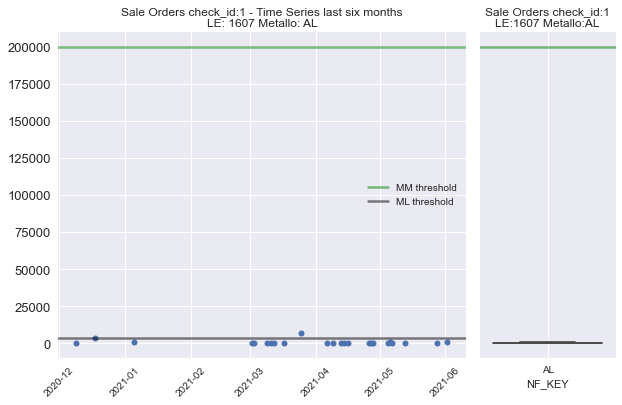

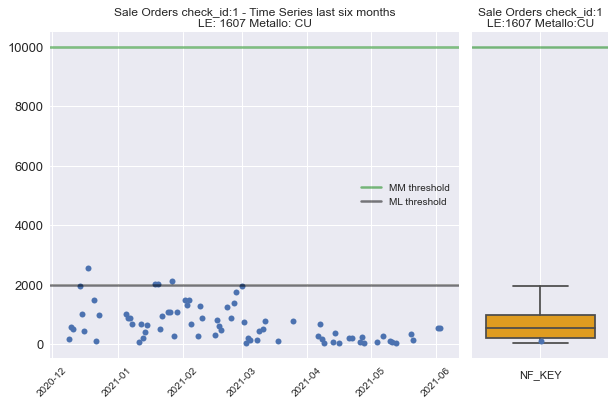

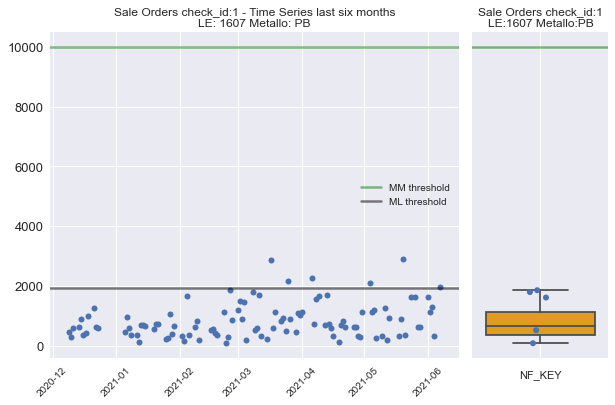

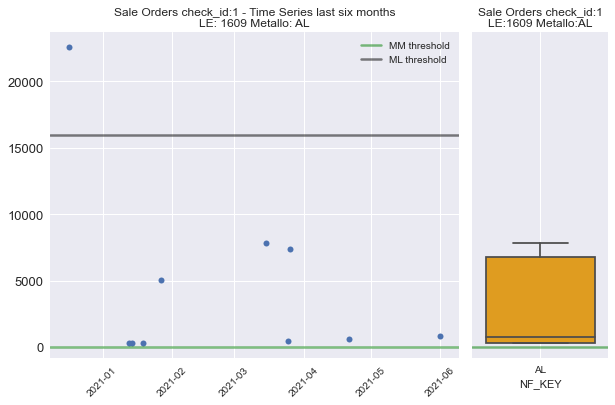

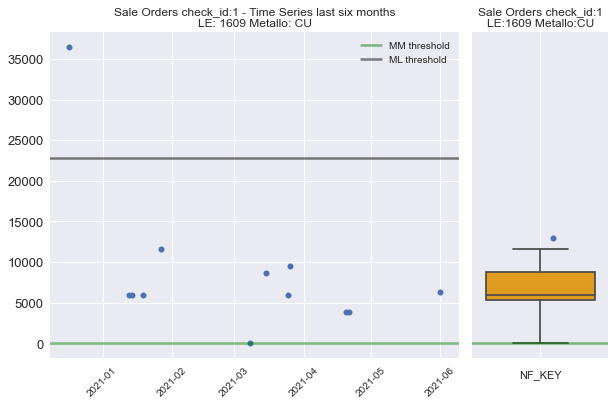

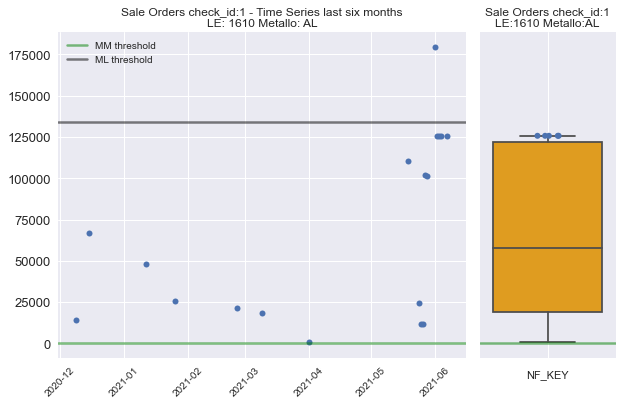

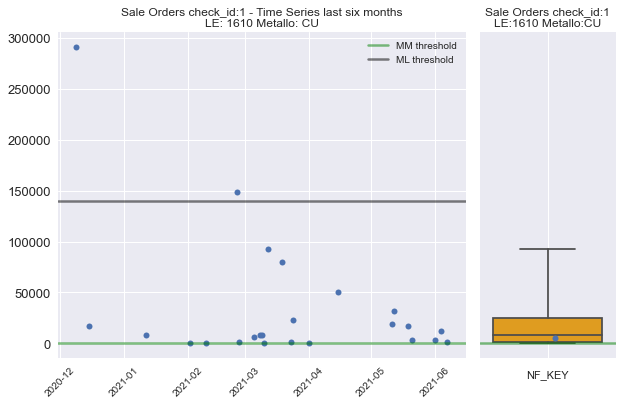

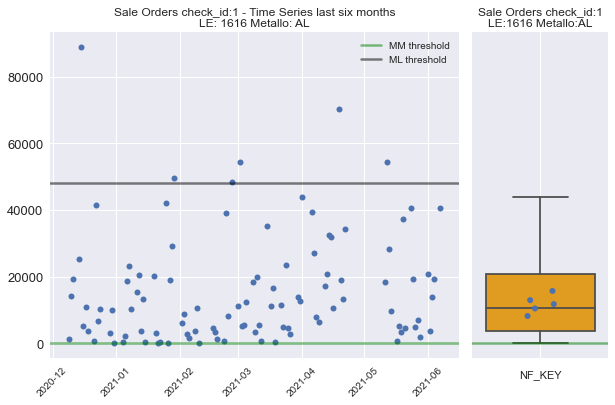

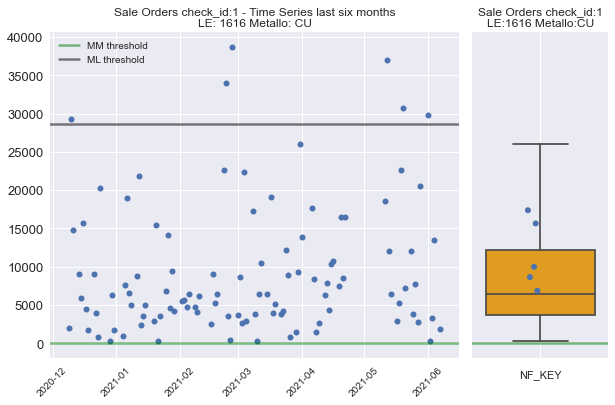

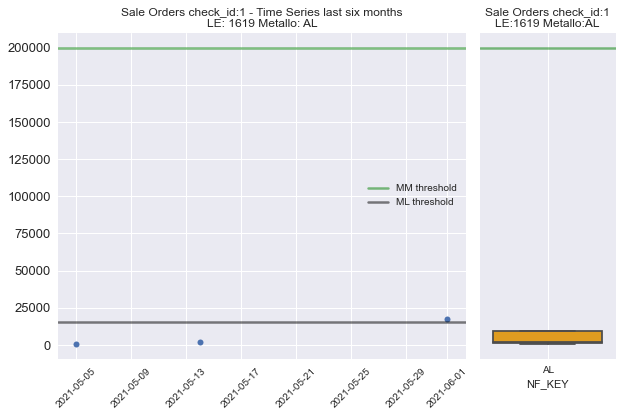

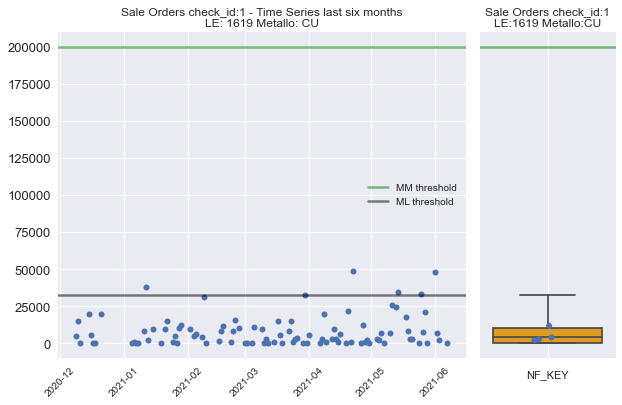

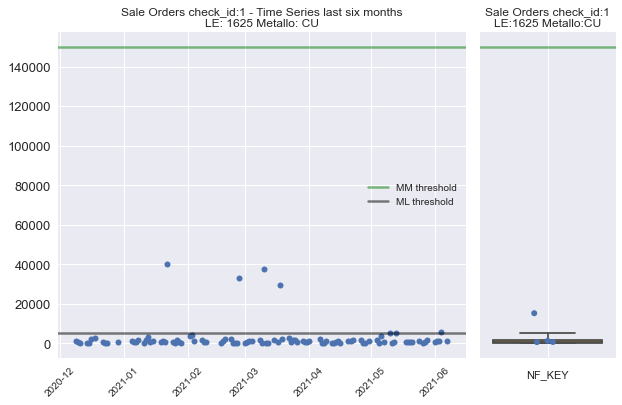

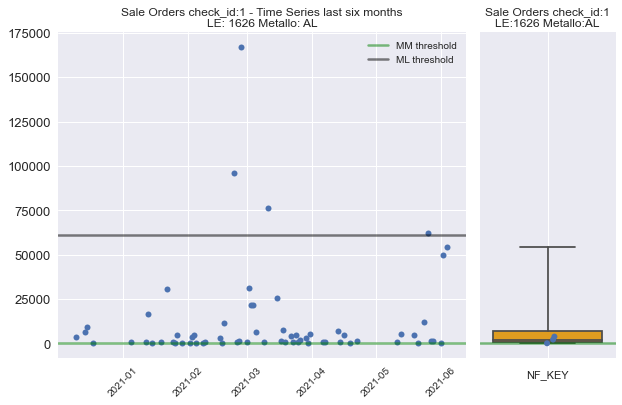

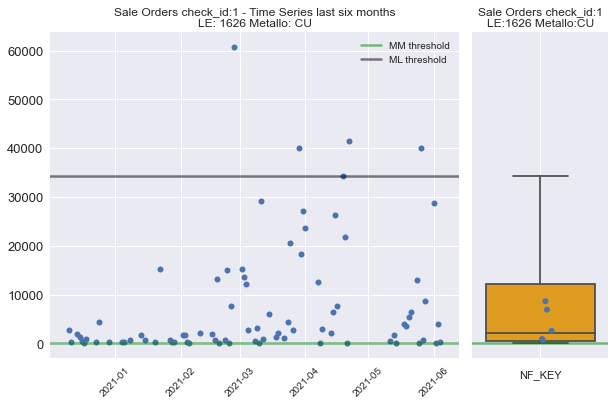

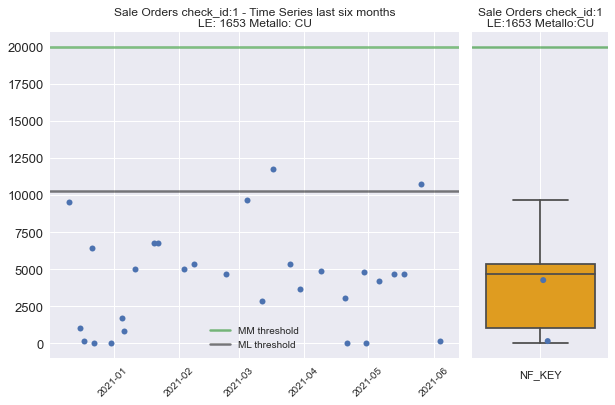

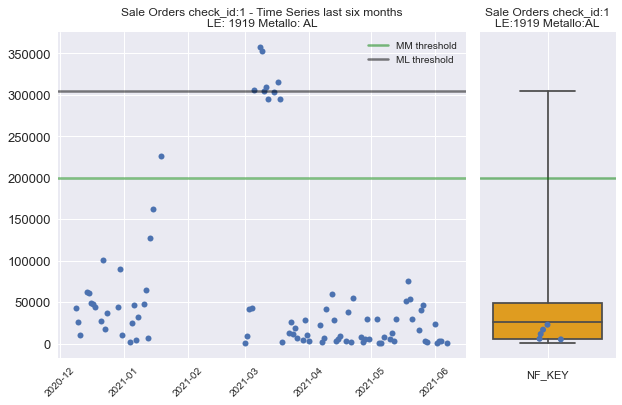

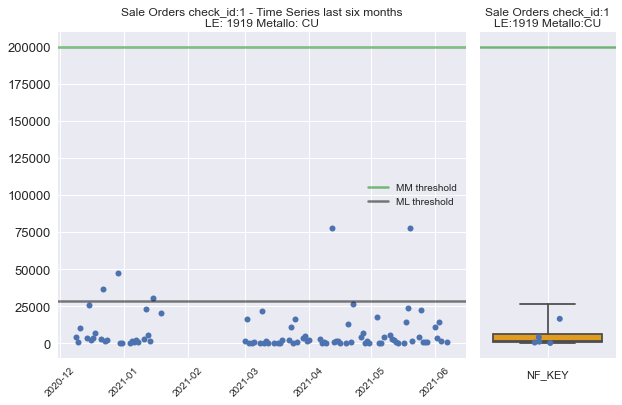

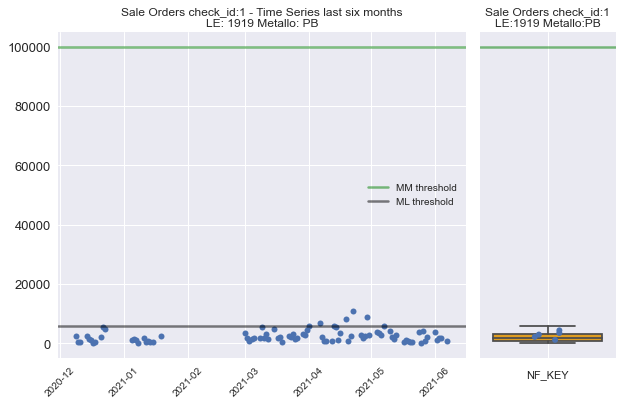

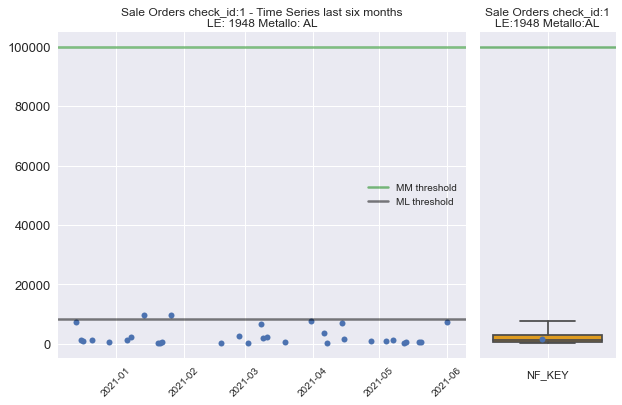

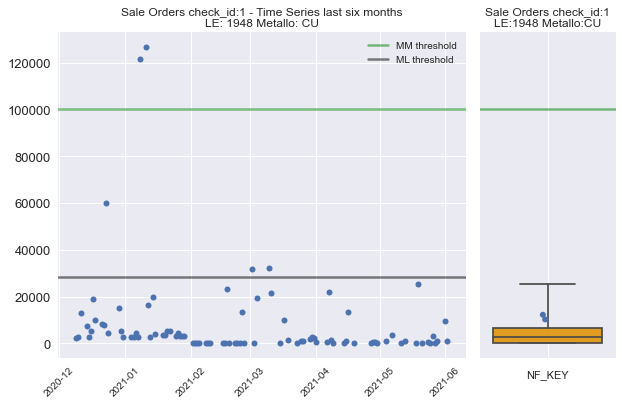

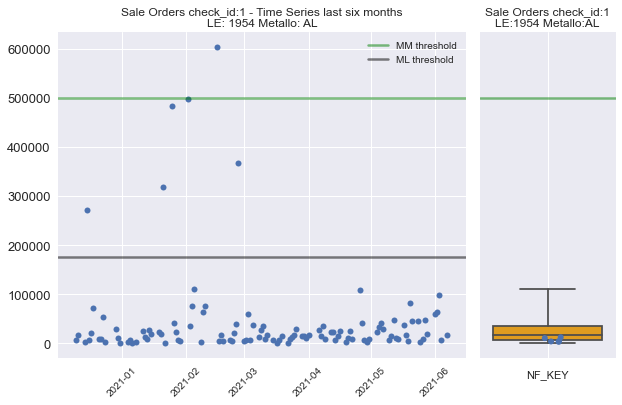

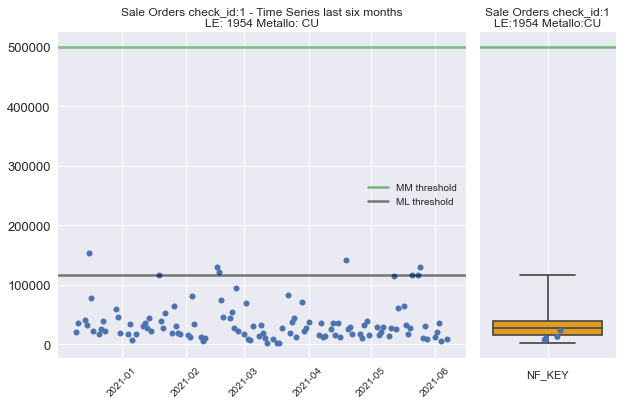

In [14]:
f.creazione_grafico(check_1_3, df_c1_soglie_995, 1, check_1_3_test, 'Sale', df_actual_thresholds, percentile_distr_high, percentile_distr_high_perc, percentile_distr_low_perc)

#### Check 2

In [15]:
check_2 = pd.DataFrame(sales_train.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()#[["COMPANY_CODE","NF_KEY","DOC_NUM","DAILY_QTY"]]
check_2_test = pd.DataFrame(sales_test.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
        
    
df_c2_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_2.COMPANY_CODE.unique():
    for i in check_2.NF_KEY.unique():
        df = check_2[(check_2["COMPANY_CODE"]==j) & (check_2["NF_KEY"]==i)]
        if len(df) != 0:
            soglia = df.DAILY_QTY.quantile(percentile_distr_high)
            new_row = {"CC":j,"metallo":i,"soglia":soglia}
            df_c2_soglie_995 = df_c2_soglie_995.append(new_row, ignore_index=True)
                
df_c2_soglie_995["check_id"] = 2

#### Check 5

In [16]:
cust_adhoc = black_list[(black_list["CUSTOMER_SUPPLIER"]=="Customer") & (black_list["ATTRIBUTE"]=="THRESHOLD") & (black_list["ACTIVE"]==1)]
metal_list = cust_adhoc.METAL.unique()
cc_list = cust_adhoc.COMPANY_CODE.unique()
cust_list = cust_adhoc.CUSTOMER_CODE.unique()
sales_list = sales_train[(sales_train["COMPANY_CODE"].isin(cc_list)) & (sales_train["NF_KEY"].isin(metal_list))]
sales_list = sales_list[sales_list["SOLD_TO_PT"].isin(cust_list)]
sales_list_test = sales_test[(sales_test["COMPANY_CODE"].isin(cc_list)) & (sales_test["NF_KEY"].isin(metal_list))]
sales_list_test = sales_list_test[sales_list_test["SOLD_TO_PT"].isin(cust_list)]
    
check_5 = pd.DataFrame(sales_list.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
check_5_test = pd.DataFrame(sales_list_test.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
        
df_c5_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_5.COMPANY_CODE.unique():
    for i in check_5.NF_KEY.unique():
        df = check_5[(check_5["COMPANY_CODE"]==j) & (check_5["NF_KEY"]==i)]
        if len(df) != 0:
            soglia = df.DAILY_QTY.quantile(percentile_distr_high)
            new_row = {"CC":j,"metallo":i,"soglia":soglia}
            df_c5_soglie_995 = df_c5_soglie_995.append(new_row, ignore_index=True)
                
df_c5_soglie_995["check_id"] = 5

#### Check 18

In [17]:
sales_debooking["DAILY_QTY"] = abs(sales_debooking["DAILY_QTY"])
sales_debooking["ORDER_QTY"] = sales_debooking["ORDER_QTY"].astype(float)

#Questo tratto di 4 righe immediatamente sotto sostituiscono le due righe commentate che seguono
sales_debooking["WORKED_DATE"] = pd.to_datetime(sales_debooking["WORKED_DATE"])
sales_debooking["WORKED_DATE"] = sales_debooking["WORKED_DATE"].dt.date
sales_deb_train = sales_debooking[sales_debooking["WORKED_DATE"].isin(lista_date_train)]
sales_deb_test = sales_debooking[sales_debooking["WORKED_DATE"].isin(lista_date_test)]
'''
sales_deb_train = sales_debooking[sales_debooking["WORKED_DATE"].dt.date.isin(lista_date_train)]
sales_deb_test = sales_debooking[sales_debooking["WORKED_DATE"].dt.date.isin(lista_date_test)]
'''

check_18_n = pd.DataFrame(sales_deb_train.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
check_18_d = pd.DataFrame(sales_deb_train.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["ORDER_QTY"].sum()).reset_index()
check_18 = check_18_n
check_18["den"] = check_18_d["ORDER_QTY"]
check_18 = check_18.rename(columns={"den":"ORDER_QTY"})
check_18["RATIO"] = check_18["DAILY_QTY"]/check_18["ORDER_QTY"] * 100

check_18_n = pd.DataFrame(sales_deb_test.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
check_18_d = pd.DataFrame(sales_deb_test.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["ORDER_QTY"].sum()).reset_index()
check_18_test = check_18_n
check_18_test["den"] = check_18_d["ORDER_QTY"]
check_18_test = check_18_test.rename(columns={"den":"ORDER_QTY"})
check_18_test["RATIO"] = check_18_test["DAILY_QTY"]/check_18_test["ORDER_QTY"] * 100

df_c18_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_18.COMPANY_CODE.unique():
    for i in check_18.NF_KEY.unique():
        df = check_18[(check_18["COMPANY_CODE"]==j) & (check_18["NF_KEY"]==i)]
        if len(df) != 0:
            soglia = df.RATIO.quantile(percentile_distr_high)
            new_row = {"CC":j,"metallo":i,"soglia":soglia}
            df_c18_soglie_995 = df_c18_soglie_995.append(new_row, ignore_index=True)
                
df_c18_soglie_995["check_id"] = 18

#### Check 21

Da controllare

In [18]:
#check ogni line item di un DOC_NUM abbia stesso RD_KEY
check_19 = pd.DataFrame(sales.groupby(["DOC_NUM", "WORKED_DATE", "BOOKING_FR"])["RD_KEY"].nunique()).reset_index()
check_19 = check_19[check_19["RD_KEY"] == 1]
    
#esclusione ordini con più di una BOOKING_FR distinta per DOC_NUM e WORKED_DATE
excluded_orders = pd.DataFrame(check_19.groupby(["DOC_NUM", "WORKED_DATE"])["BOOKING_FR"].nunique()).reset_index()
excluded_orders = excluded_orders[excluded_orders["BOOKING_FR"]>1]
check_19 = check_19.merge(excluded_orders, how="left", on = ["DOC_NUM","WORKED_DATE"])
check_19 = check_19[check_19["BOOKING_FR_y"].isna()]
check_19 = check_19[["DOC_NUM","WORKED_DATE","BOOKING_FR_x", "RD_KEY"]].rename(columns={"BOOKING_FR_x":"BOOKING_FR"})

check_19["WORKED_DATE"] = pd.to_datetime(check_19["WORKED_DATE"])
check_19["WORKED_DATE"] = check_19["WORKED_DATE"].dt.date
check_19["BOOKING_FR"] = pd.to_datetime(check_19["BOOKING_FR"])
check_19["BOOKING_FR"] = check_19["BOOKING_FR"].dt.date
check_19_train = check_19[check_19["WORKED_DATE"].isin(lista_date_train)]
check_19_test = check_19[check_19["WORKED_DATE"].isin(lista_date_test)]
'''
check_19_train = check_19[check_19["WORKED_DATE"].dt.date.isin(lista_date_train)]
check_19_test = check_19[check_19["WORKED_DATE"].dt.date.isin(lista_date_test)]
'''

check_21 = check_19_train.assign(dt_diff = 0)
check_21["dt_diff"] = check_21.WORKED_DATE - check_21.BOOKING_FR
check_21 = check_21[check_21["dt_diff"] <= np.timedelta64(7, 'D')]
    
tab_join_s = check_21.merge(sales_train[["DOC_NUM", "WORKED_DATE", "DAILY_QTY", "NF_KEY", "COMPANY_CODE", "BOOKING_FR"]],
                               on = ["DOC_NUM", "WORKED_DATE", "BOOKING_FR"])
check_21 = pd.DataFrame(tab_join_s.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()#[["COMPANY_CODE","NF_KEY","DOC_NUM","DAILY_QTY"]]
    
check_21_test = check_19_test.assign(dt_diff = 0)
check_21_test["dt_diff"] = check_21_test.WORKED_DATE - check_21_test.BOOKING_FR
check_21_test = check_21_test[check_21_test["dt_diff"] <= np.timedelta64(7, 'D')]
    
tab_join_s = check_21_test.merge(sales_test[["DOC_NUM", "WORKED_DATE", "DAILY_QTY", "NF_KEY", "COMPANY_CODE", "BOOKING_FR"]],
                               on = ["DOC_NUM", "WORKED_DATE", "BOOKING_FR"])
check_21_test = pd.DataFrame(tab_join_s.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
 
    
df_c21_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_21.COMPANY_CODE.unique():
    for i in check_21.NF_KEY.unique():
        df = check_21[(check_21["COMPANY_CODE"]==j) & (check_21["NF_KEY"]==i)]
        if len(df) != 0:
            soglia = df.DAILY_QTY.quantile(percentile_distr_high)
            new_row = {"CC":j,"metallo":i,"soglia":soglia}
            df_c21_soglie_995 = df_c21_soglie_995.append(new_row, ignore_index=True)
                
df_c21_soglie_995["check_id"] = 21

### Creo il set di PURCHASE
Utili per l'analisi dei check 6,7,8,10,17,20

In [19]:
purchase = ordini_totali[(ordini_totali["CONVERSION_NOT_SUCCEDED"] == 'B') & (ordini_totali["F"] == 'O') & (~ordini_totali["SALES_DOC_TY"].isin(["OVER","UNDE"]))]
purchase_debooking = purchase[purchase["DAILY_QTY"] > 0]
purchase = purchase[purchase["DAILY_QTY"] < 0]
purchase["DAILY_QTY"] = abs(purchase["DAILY_QTY"])

In [20]:
purchase["WORKED_DATE"] = pd.to_datetime(purchase["WORKED_DATE"])
purchase["WORKED_DATE"] = purchase["WORKED_DATE"].dt.date
purchase_train = purchase[purchase["WORKED_DATE"].isin(lista_date_train)]
purchase_test = purchase[purchase["WORKED_DATE"].isin(lista_date_test)]

#### Check 6 e 8

In [21]:
check_6_8 = pd.DataFrame(purchase_train.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE"])["DAILY_QTY"].sum()).reset_index()
check_6_8_test = pd.DataFrame(purchase_test.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE"])["DAILY_QTY"].sum()).reset_index()

df_c6_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
df_c8_soglie_1 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_6_8.COMPANY_CODE.unique():
    for i in check_6_8.NF_KEY.unique():
        df = check_6_8[(check_6_8["COMPANY_CODE"]==j) & (check_6_8["NF_KEY"]==i)]
        if len(df) != 0:
            soglia_6 = df.DAILY_QTY.quantile(percentile_distr_high)
            soglia_8 = df.DAILY_QTY.quantile(percentile_distr_low)
            if interq_threshold == 'si':
                iq_soglia_8 = interquartile_threshold(df, 8)
                if (iq_soglia_8 < soglia_8) & (iq_soglia_8 >= 0):
                    #print(soglia_8)
                    soglia_8 = iq_soglia_8
                    #print('Soglia interq attivata', soglia_8)
            new_row_6 = {"CC":j,"metallo":i,"soglia":soglia_6}
            new_row_8 = {"CC":j,"metallo":i,"soglia":soglia_8}
            df_c6_soglie_995 = df_c6_soglie_995.append(new_row_6, ignore_index=True)
            df_c8_soglie_1 = df_c8_soglie_1.append(new_row_8, ignore_index=True)
                
df_c6_soglie_995["check_id"] = 6
df_c8_soglie_1["check_id"] = 8

#### Check 7

In [22]:
check_7 = purchase[~purchase.DOC_NUM.str.startswith("27")]
check_7 = pd.DataFrame(purchase_train.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()#[["COMPANY_CODE","NF_KEY","DOC_NUM","DAILY_QTY"]]
check_7_test = pd.DataFrame(purchase_test.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()#[["COMPANY_CODE","NF_KEY","DOC_NUM","DAILY_QTY"]]
        
    
    
df_c7_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_7.COMPANY_CODE.unique():
    for i in check_7.NF_KEY.unique():
        df = check_7[(check_7["COMPANY_CODE"]==j) & (check_7["NF_KEY"]==i)]
        if len(df) != 0:
            soglia = df.DAILY_QTY.quantile(percentile_distr_high)
            new_row = {"CC":j,"metallo":i,"soglia":soglia}
            df_c7_soglie_995 = df_c7_soglie_995.append(new_row, ignore_index=True)
                
df_c7_soglie_995["check_id"] = 7

#### Check 10

In [23]:
cust_adhoc = black_list[(black_list["CUSTOMER_SUPPLIER"]=="Supplier") & (black_list["ATTRIBUTE"]=="THRESHOLD") & (black_list["ACTIVE"]==1)]
metal_list = cust_adhoc.METAL.unique()
cc_list = cust_adhoc.COMPANY_CODE.unique()
cust_list = cust_adhoc.CUSTOMER_CODE.unique()
purchase_list = purchase_train[(purchase_train["COMPANY_CODE"].isin(cc_list)) & (purchase_train["NF_KEY"].isin(metal_list))]
purchase_list = purchase_list[purchase_list["SOLD_TO_PT"].isin(cust_list)]
purchase_list_test = purchase_test[(purchase_test["COMPANY_CODE"].isin(cc_list)) & (purchase_test["NF_KEY"].isin(metal_list))]
purchase_list_test = purchase_list_test[purchase_list_test["SOLD_TO_PT"].isin(cust_list)]
    
check_10 = pd.DataFrame(purchase_list.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
check_10_test = pd.DataFrame(purchase_list_test.groupby(["COMPANY_CODE","NF_KEY","WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
        
df_c10_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_10.COMPANY_CODE.unique():
    for i in check_10.NF_KEY.unique():
        df = check_10[(check_10["COMPANY_CODE"]==j) & (check_10["NF_KEY"]==i)]
        if len(df) != 0:
            soglia = df.DAILY_QTY.quantile(percentile_distr_high)
            new_row = {"CC":j,"metallo":i,"soglia":soglia}
            df_c10_soglie_995 = df_c10_soglie_995.append(new_row, ignore_index=True)
                
df_c10_soglie_995["check_id"] = 10

#### Check 17

In [ ]:
purchase_debooking["ORDER_QTY"] = purchase_debooking["ORDER_QTY"].astype(float)
purchase_deb_train = purchase_debooking[purchase_debooking["WORKED_DATE"].dt.date.isin(lista_date_train)]
purchase_deb_test = purchase_debooking[purchase_debooking["WORKED_DATE"].dt.date.isin(lista_date_test)]
    
check_17_n = pd.DataFrame(purchase_deb_train.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
check_17_d = pd.DataFrame(purchase_deb_train.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["ORDER_QTY"].sum()).reset_index()
check_17 = check_17_n
check_17["den"] = check_17_d["ORDER_QTY"]
check_17=check_17.rename(columns={"den":"ORDER_QTY"})
check_17["RATIO"] = check_17["DAILY_QTY"]/check_17["ORDER_QTY"]
    
check_17_n = pd.DataFrame(purchase_deb_test.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["DAILY_QTY"].sum()).reset_index()
check_17_d = pd.DataFrame(purchase_deb_test.groupby(["COMPANY_CODE","NF_KEY", "WORKED_DATE","DOC_NUM"])["ORDER_QTY"].sum()).reset_index()
check_17_test = check_17_n
check_17_test["den"] = check_17_d["ORDER_QTY"]
check_17_test = check_17_test.rename(columns={"den":"ORDER_QTY"})
check_17_test["RATIO"] = check_17_test["DAILY_QTY"]/check_17_test["ORDER_QTY"]
    
df_c17_soglie_995 = pd.DataFrame(columns=(["CC","metallo","soglia"]))
    
for j in check_17.COMPANY_CODE.unique():
    for i in check_17.NF_KEY.unique():
        df = check_17[(check_17["COMPANY_CODE"]==j) & (check_17["NF_KEY"]==i)]
        if len(df) != 0:
            soglia = df.RATIO.quantile(percentile_distr_high)
            new_row = {"CC":j,"metallo":i,"soglia":soglia}
            df_c17_soglie_995 = df_c17_soglie_995.append(new_row, ignore_index=True)
                
df_c17_soglie_995["check_id"] = 17